# Dimensionality vs Performance

Benchmarking of GP training performance against input and spectrum size.

**Author:** Brian Schubert &lt;<schubert.b@northeastern.edu>&gt;

**Date:** 07 September 2023


In [2]:
import timeit
import warnings
from typing import Final


import matplotlib.pyplot as plt
import numpy as np

import sklearn.base as skl_base
import sklearn.decomposition as skl_decomp
import sklearn.gaussian_process as skl_gp
import sklearn.pipeline
import sklearn.preprocessing as skl_pre
import xarray as xr 

import sklearn.exceptions as skl_except


MAX_SWEEP_WORKERS: Final = 24

In [101]:
# Fixed spectrum to simulate.
# Note: even though 6S's lower bound is 0.2 um, it generates a handful of nan values
# below 0.25 um.
# WAVELENGTHS: Final = np.arange(0.25, 4, 0.0025)  # micrometers
# 
# NUM_INPUT_DIMS: Final = 20

In [102]:
# Number of LHS samples to draw.
# NUM_SAMPLES: Final = 100
# 
# # Draw LHS samples.
# rng = np.random.default_rng(2023_09_01)
# lhs_sampler = sci_qmc.LatinHypercube(d=NUM_INPUT_DIMS, seed=rng)
# input_samples = lhs_sampler.random(NUM_SAMPLES)
# 
# sythn_output = input_samples.sum(axis=1, keepdims=True) + rng.uniform(0, 0.2, size=(NUM_SAMPLES, 1)) + np.cos(20*np.pi/WAVELENGTHS[-1]-WAVELENGTHS[0]*np.arange(WAVELENGTHS.size)).reshape(1, -1)
# print(f"{input_samples.shape}, {train_output.shape=}")

In [6]:
train_results = xr.load_dataset("sweep_17f664c59f.nc")  # "sweep_bf74684d53.nc"
# train_results_stacked = train_results.stack(inputs=[d for d in train_results.dims if "wavelength" not in d])
train_output = train_results.total_transmission
display(train_output)

<xarray.DataArray 'total_transmission' (lhs: 100, wavelength.value: 1500)>
array([[0.        , 0.        , 0.        , ..., 0.93036955, 0.93019431,
        0.93002877],
       [0.        , 0.        , 0.        , ..., 0.90423174, 0.90389809,
        0.90354541],
       [0.        , 0.        , 0.        , ..., 0.91208246, 0.91178844,
        0.9114944 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.92621   , 0.92598465,
        0.92574952],
       [0.        , 0.        , 0.        , ..., 0.86240642, 0.86196445,
        0.86154104],
       [0.        , 0.        , 0.        , ..., 0.94049738, 0.9402387 ,
        0.93997951]])
Coordinates:
  * wavelength.value              (wavelength.value) float64 0.25 ... 3.998
  * lhs                           (lhs) int32 0 1 2 3 4 5 ... 94 95 96 97 98 99
    atmosphere.ozone              (lhs) float64 0.2728 0.4257 ... 0.4273 0.333
    atmosphere.water              (lhs) float64 3.51 3.305 1.191 ... 1.661 2.581
    aerosol_profile.aot           (lhs) float64 0.3987 0.214 ... 0.234 0.06212
    geometry.solar_zenith.cosine  (lhs) float64 0.8125 0.6748 ... 0.5034 0.7464
Attributes:
    title:    Total Transmission
    unit:     1

In [7]:

pca_pipe = sklearn.pipeline.Pipeline(
    [
        ("scale", skl_pre.StandardScaler(with_std=False)),
        # white=True - scale down PC components by singular values so that the output features are isotropic.
        ("pca", skl_decomp.PCA(n_components=None, whiten=True)),
    ]
)

trial_num_samples = [10,40,60,100]
trial_spectrum_sizes = np.logspace(2, np.log10(train_output.values.shape[-1]), 100, dtype=int)

pca_trial_results = np.empty(shape=(len(trial_num_samples), len(trial_spectrum_sizes)))

def trial_pca(data):
    sklearn.base.clone(pca_pipe).fit(data)
    

for samples_idx, samples in enumerate(trial_num_samples):
    for spec_idx, spec_size in enumerate(trial_spectrum_sizes):
        # print(f"Benchmarking {input_dims=:2d},{spec_size=:4d}... ", end="")
        runtimes = timeit.repeat(lambda: trial_pca(train_output.values[:samples, :spec_size]), repeat=3, number=1)
        avg = np.mean(runtimes)
        pca_trial_results[samples_idx, spec_idx] = avg
        # print(f"{avg:8f}")

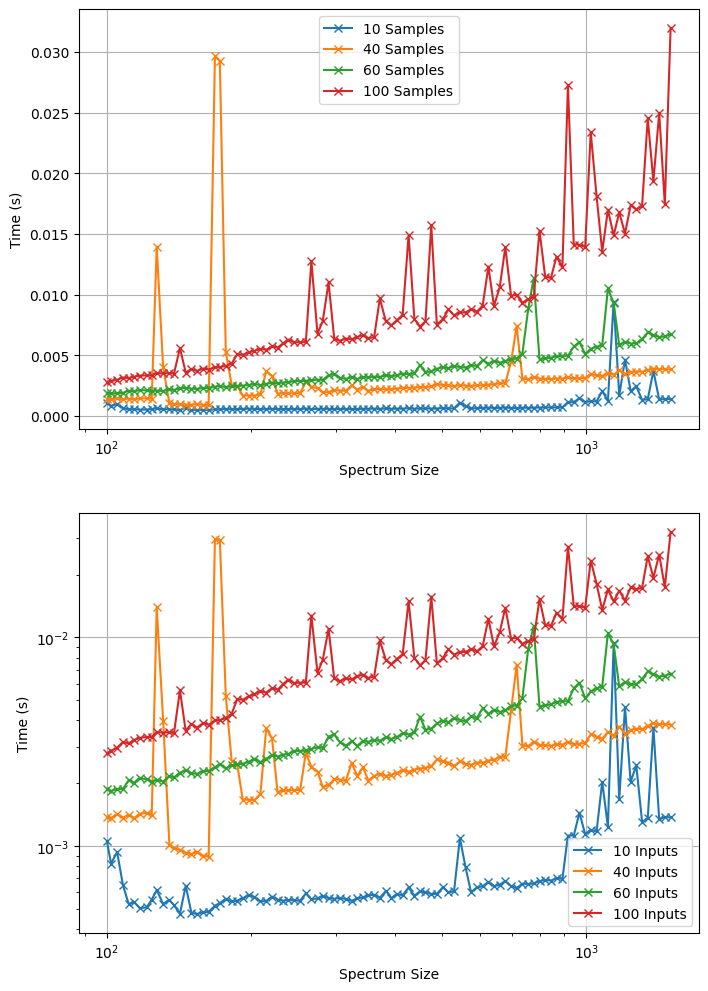

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(8,12))

for samples_idx, samples in enumerate(trial_num_samples):
    
    ax = axs[0]
    ax.semilogx(
        trial_spectrum_sizes,
        pca_trial_results[samples_idx, :],
        "x-",
        label=f"{samples} Samples"
    )
    ax.legend()
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Spectrum Size")
    ax.grid(True)
    
    ax = axs[1]
    ax.loglog(
        trial_spectrum_sizes,
        pca_trial_results[samples_idx, :],
        "x-",
        label=f"{samples} Inputs"
    )
    ax.legend()
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Spectrum Size")
    ax.grid(True)
    

In [9]:
# NUM_TRAIN_COMPONENTS: Final = 6
pca_pipe.set_params(pca__n_components=None)
pca_pipe.fit(train_output)

print(pca_pipe.named_steps["pca"].singular_values_)
print(pca_pipe.named_steps["pca"].explained_variance_)

# for wavelength, pc_contrib in zip(
#     WAVELENGTHS, pca_pipe.named_steps["pca"].components_.T
# ):
#     print(f" {wavelength*1e3:6.1f}nm: {' '.join(f'{c:7.4f}' for c in pc_contrib)}")

[1.49453622e+01 6.87763018e+00 2.51387896e+00 1.06107081e+00
 8.97414063e-01 2.94469214e-01 1.42323250e-01 9.82363017e-02
 7.60807299e-02 5.72598007e-02 3.98390831e-02 3.33053273e-02
 3.10948610e-02 2.15876459e-02 1.13757776e-02 6.89669063e-03
 5.94265231e-03 5.25430542e-03 4.17727248e-03 3.31223904e-03
 2.55078905e-03 2.27615331e-03 1.69602723e-03 1.42354883e-03
 1.27011519e-03 1.05058950e-03 9.40838598e-04 7.28084776e-04
 7.00567087e-04 6.17928059e-04 5.00696479e-04 4.45676722e-04
 3.83333925e-04 3.00429276e-04 2.78107234e-04 2.46969154e-04
 2.10314056e-04 1.83830649e-04 1.74918104e-04 1.67906834e-04
 1.61900046e-04 1.58990856e-04 1.55117072e-04 1.53022069e-04
 1.49922356e-04 1.49590567e-04 1.47688579e-04 1.46331825e-04
 1.45958105e-04 1.44589620e-04 1.44039820e-04 1.41744190e-04
 1.41142736e-04 1.40430500e-04 1.40003987e-04 1.39313002e-04
 1.38889810e-04 1.36807795e-04 1.35988008e-04 1.34931305e-04
 1.34330307e-04 1.32869440e-04 1.32580497e-04 1.31293114e-04
 1.31076589e-04 1.298268

In [10]:
train_output.coords.keys()

KeysView(Coordinates:
  * wavelength.value              (wavelength.value) float64 0.25 ... 3.998
  * lhs                           (lhs) int32 0 1 2 3 4 5 ... 94 95 96 97 98 99
    atmosphere.ozone              (lhs) float64 0.2728 0.4257 ... 0.4273 0.333
    atmosphere.water              (lhs) float64 3.51 3.305 1.191 ... 1.661 2.581
    aerosol_profile.aot           (lhs) float64 0.3987 0.214 ... 0.234 0.06212
    geometry.solar_zenith.cosine  (lhs) float64 0.8125 0.6748 ... 0.5034 0.7464)

In [11]:
# Shape: (examples) x (features)
x_train = np.stack(
    [train_output.coords[parameter].values for parameter in train_output.coords.keys() if parameter not in ("wavelength.value", "lhs")],
    axis=-1,
)

# Shape: (examples) x (pcs)
y_train = pca_pipe.transform(train_output)
print(f"{x_train.shape=}, {y_train.shape=}")

x_train.shape=(100, 4), y_train.shape=(100, 100)


In [12]:
kernel = 1.0 * skl_gp.kernels.RBF()  # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = skl_gp.GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-2,
    # alpha=1,
    # Normalize targets to zero means, unit variance.
    normalize_y=True,
)

pipeline = sklearn.pipeline.Pipeline(
    [
        # Rescale input features to [0, 1].
        # ("scale", sklearn_pre.MinMaxScaler()),
        # Rescale to zero mean.
        # ("normalize", skl_pre.StandardScaler(with_std=False)),
        ("gp", gaussian_process),
    ]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

pc_models = [skl_base.clone(pipeline) for _ in range(y_train.shape[-1])]

Pipeline(steps=[('gp',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=20,
                                          normalize_y=True))])

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

In [13]:
def fit_model(num_samples, num_pcs):
    for pc_idx, model in enumerate(pc_models[:num_pcs]):
        model.fit(x_train[:num_samples], y_train[:num_samples, pc_idx])
        
trial_gp_num_samples = [2,4,8,16,32,64,100]
trial_gp_num_pcs = [2,5,10,20]

trial_gp_results = np.empty((len(trial_gp_num_samples), len(trial_gp_num_pcs)))

for idx_samples, samples in enumerate(trial_gp_num_samples):
    for idx_pcs, pcs in enumerate(trial_gp_num_pcs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", skl_except.ConvergenceWarning)
            runtimes = timeit.repeat(lambda: fit_model(samples, pcs),repeat=2, number=1)
        trial_gp_results[idx_samples,idx_pcs] = np.mean(runtimes)


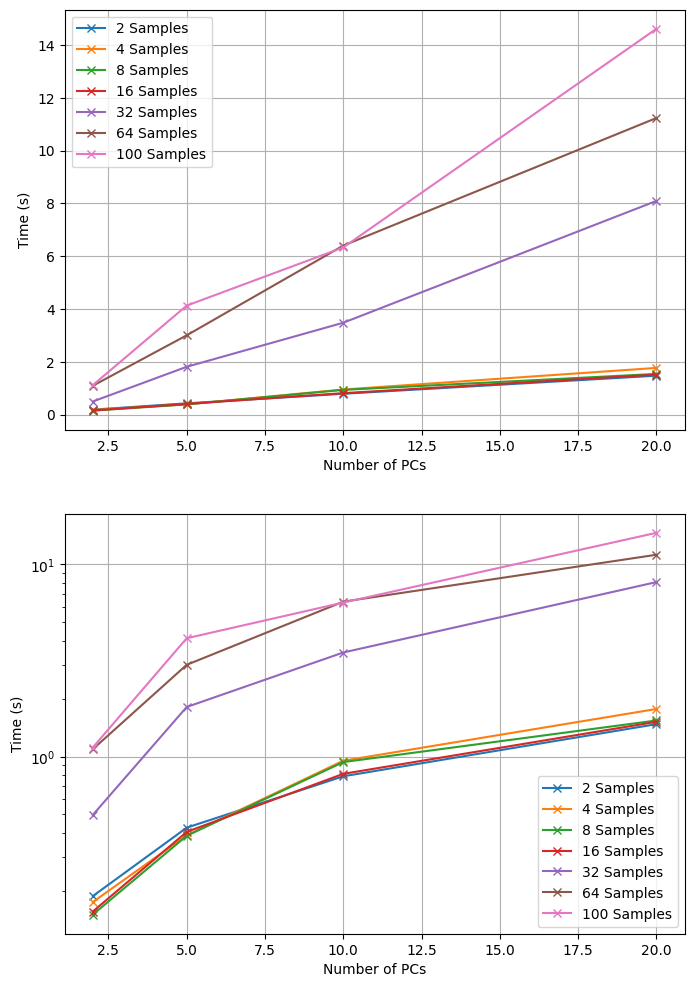

In [111]:
fig, axs = plt.subplots(nrows=2, figsize=(8,12))

for idx_samples, samples in enumerate(trial_gp_num_samples):
    
    ax = axs[0]
    ax.plot(
        trial_gp_num_pcs,
        trial_gp_results[idx_samples, :],
        "x-",
        label=f"{samples} Samples"
    )
    ax.legend()
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Number of PCs")
    ax.grid(True)
    
    ax = axs[1]
    ax.semilogy(
        trial_gp_num_pcs,
        trial_gp_results[idx_samples, :],
        "x-",
        label=f"{samples} Samples"
    )
    ax.legend()
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Number of PCs")
    ax.grid(True)